# Anomaliedetectie a.d.h.v. interkwartielafstanden op de machine temperatuur tijdreeks

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import date, timedelta
import time

### Inlezen van de data

In [3]:
temperature_data = pd.read_csv('./machine_temperature_system_failure.csv')
temperature_data['timestamp'] = pd.to_datetime(temperature_data['timestamp'])
print(temperature_data)

                timestamp      value
0     2013-12-02 21:15:00  73.967322
1     2013-12-02 21:20:00  74.935882
2     2013-12-02 21:25:00  76.124162
3     2013-12-02 21:30:00  78.140707
4     2013-12-02 21:35:00  79.329836
...                   ...        ...
22690 2014-02-19 15:05:00  98.185415
22691 2014-02-19 15:10:00  97.804168
22692 2014-02-19 15:15:00  97.135468
22693 2014-02-19 15:20:00  98.056852
22694 2014-02-19 15:25:00  96.903861

[22695 rows x 2 columns]


### Detecteren van anomalieën a.d.h.v. interkwartielafstanden op basis van 1 week data

In [28]:
anomalies_week = pd.DataFrame()

window_size = timedelta(weeks=1)

start_time = time.time()
for _, row in temperature_data.iterrows():
    # raam van 1 week data opvragen
    current_timestamp = row['timestamp']
    week_prior = current_timestamp - window_size
    data_past_week = temperature_data[(temperature_data['timestamp'] >= week_prior) & (temperature_data['timestamp'] <= current_timestamp)]
    
    # kwartielen Q1 en Q3 waarde bepalen en interkwartiel afstand
    quantiles = data_past_week['value'].quantile([0.25, 0.75])
    iqr = quantiles[0.75] - quantiles[0.25]
    
    # grens anomalieën bepalen
    min_value = quantiles[0.25] - 1.5*iqr
    max_value = quantiles[0.75] + 1.5*iqr
    
    #controleren of datapunt als anomalie beschouwd wordt
    if not min_value <= row['value'] <= max_value:
        anomalies_week = anomalies_week.append(row)
        
execution_time = time.time() - start_time

In [29]:
print(f'Script executed in: {execution_time} seconds')
print('')
print(anomalies_week)

Script executed in: 36.264312982559204 seconds

                timestamp      value
171   2013-12-03 11:30:00  73.505730
173   2013-12-03 11:40:00  72.687412
174   2013-12-03 11:45:00  73.525539
175   2013-12-03 11:50:00  72.827211
176   2013-12-03 11:55:00  72.775299
...                   ...        ...
19510 2014-02-08 14:05:00  27.052230
19511 2014-02-08 14:10:00  26.903342
19512 2014-02-08 14:15:00  26.438063
19515 2014-02-08 14:30:00  25.887752
22399 2014-02-18 14:50:00  80.969539

[1485 rows x 2 columns]


### Plotten van de data met aanduiding van de gedetecteerde anomalieën

In [30]:
# Kolom met timestamps omzetten naar DateTime types en instellen als index voor het originele DataFrame
temperature_timestamp_index_week = temperature_data.copy(deep=True)
temperature_timestamp_index_week['timestamp'] = pd.to_datetime(temperature_timestamp_index_week['timestamp'])
temperature_timestamp_index_week = temperature_timestamp_index_week.set_index('timestamp')

# Timestamp bij anomalieën ook omzetten naar DateTime types
anomalies_week['timestamp'] = pd.to_datetime(anomalies_week['timestamp'])

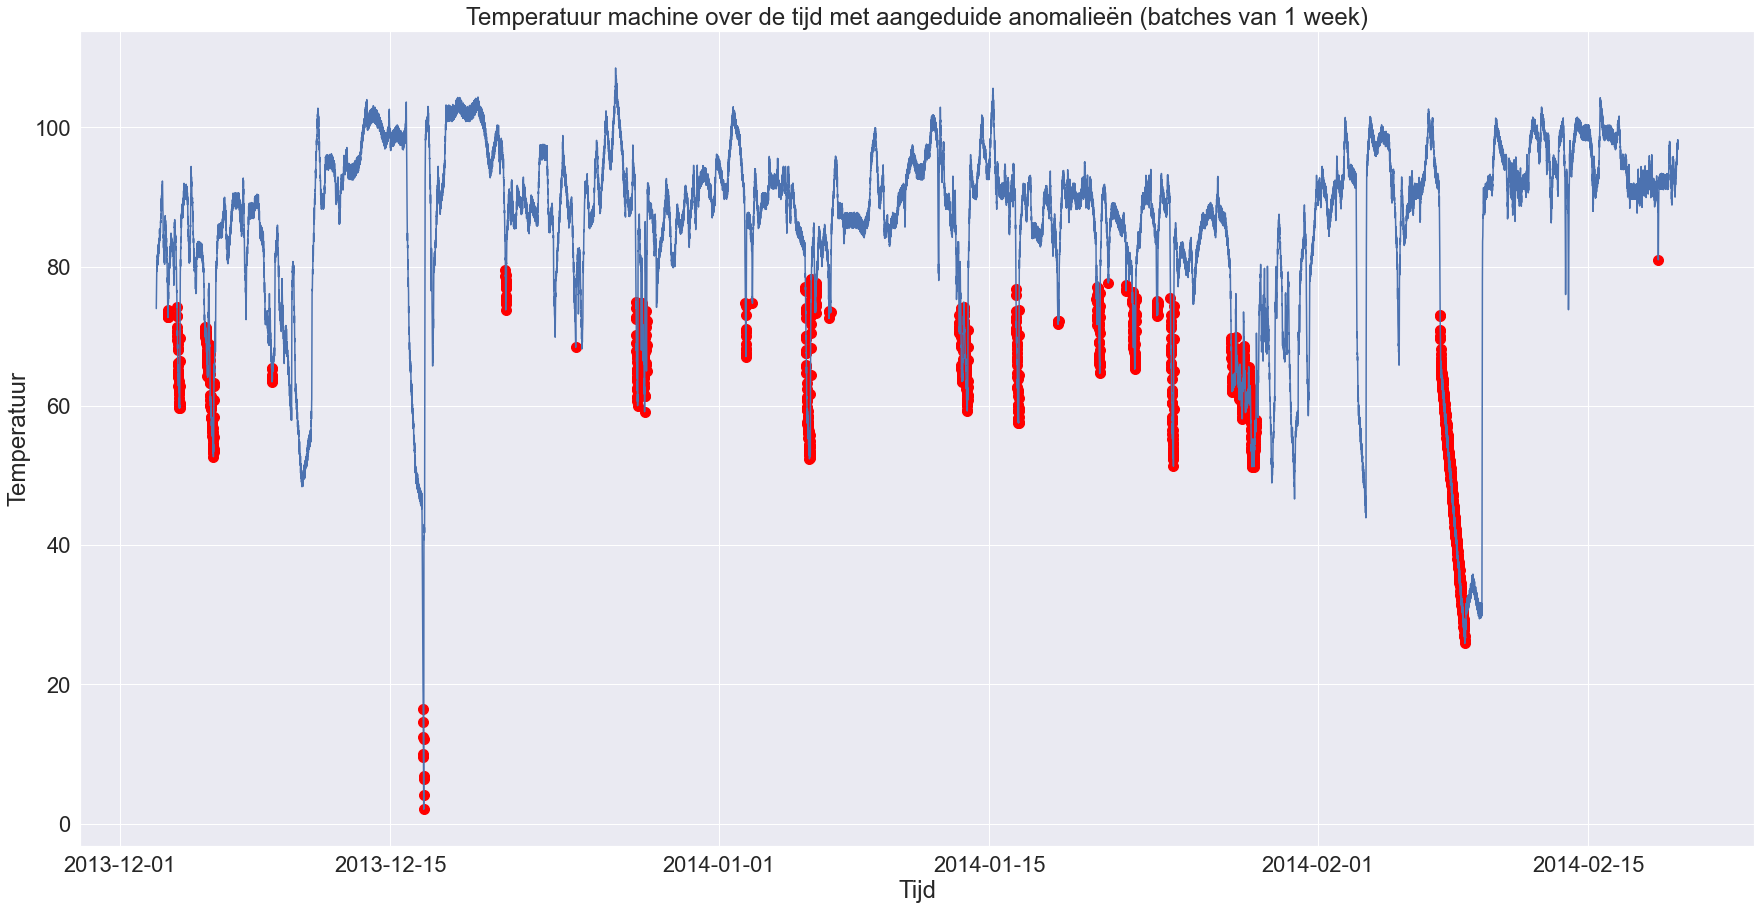

In [31]:
# Plotten van beide grafieken
sns.set(rc={'figure.figsize':(30,15)})
sns.set(font_scale=2)

plt.plot(temperature_timestamp_index_week.index, temperature_timestamp_index_week['value'])
plt.scatter(anomalies_week['timestamp'], anomalies_week['value'], c='Red', s=100)
plt.xlabel("Tijd")
plt.ylabel("Temperatuur")
plt.title("Temperatuur machine over de tijd met aangeduide anomalieën (batches van 1 week)")
plt.show()

### Detecteren van anomalieën a.d.h.v. interkwartielafstanden op basis van 3 dagen data

In [62]:
anomalies_days = pd.DataFrame(columns=['timestamp', 'value'])
start_time = time.time()
for _, row in temperature_data.iterrows():
    # get batch of previous 2 days of data
    current_timestamp = row['timestamp']
    days_prior = current_timestamp - timedelta(days=3)
    past_days_data = temperature_data[(temperature_data['timestamp'] >= days_prior) & (temperature_data['timestamp'] <= current_timestamp)]
    quantiles = past_days_data['value'].quantile([0.25, 0.75])
    iqr = quantiles[0.75] - quantiles[0.25]
    min_value = quantiles[0.25] - 1.5*iqr
    max_value = quantiles[0.75] + 1.5*iqr
    if not min_value <= row['value'] <= max_value:
        anomalies_days = anomalies_days.append(row)
        
execution_time_days = time.time() - start_time

In [63]:
print(f'Script executed in: {execution_time_days} seconds')
print('')
print(anomalies_days)

Script executed in: 37.429821729660034 seconds

                timestamp      value
171   2013-12-03 11:30:00  73.505730
173   2013-12-03 11:40:00  72.687412
174   2013-12-03 11:45:00  73.525539
175   2013-12-03 11:50:00  72.827211
176   2013-12-03 11:55:00  72.775299
...                   ...        ...
22689 2014-02-19 15:00:00  97.360905
22690 2014-02-19 15:05:00  98.185415
22691 2014-02-19 15:10:00  97.804168
22692 2014-02-19 15:15:00  97.135468
22693 2014-02-19 15:20:00  98.056852

[2034 rows x 2 columns]


In [64]:
# Kolom met timestamps omzetten naar DateTime types en instellen als index voor het originele DataFrame
temperature_timestamp_index_days = temperature_data.copy(deep=True)
temperature_timestamp_index_days['timestamp'] = pd.to_datetime(temperature_timestamp_index_days['timestamp'])
temperature_timestamp_index_days = temperature_timestamp_index_days.set_index('timestamp')

# Timestamp bij anomalieën ook omzetten naar DateTime types
anomalies_days['timestamp'] = pd.to_datetime(anomalies_days['timestamp'])

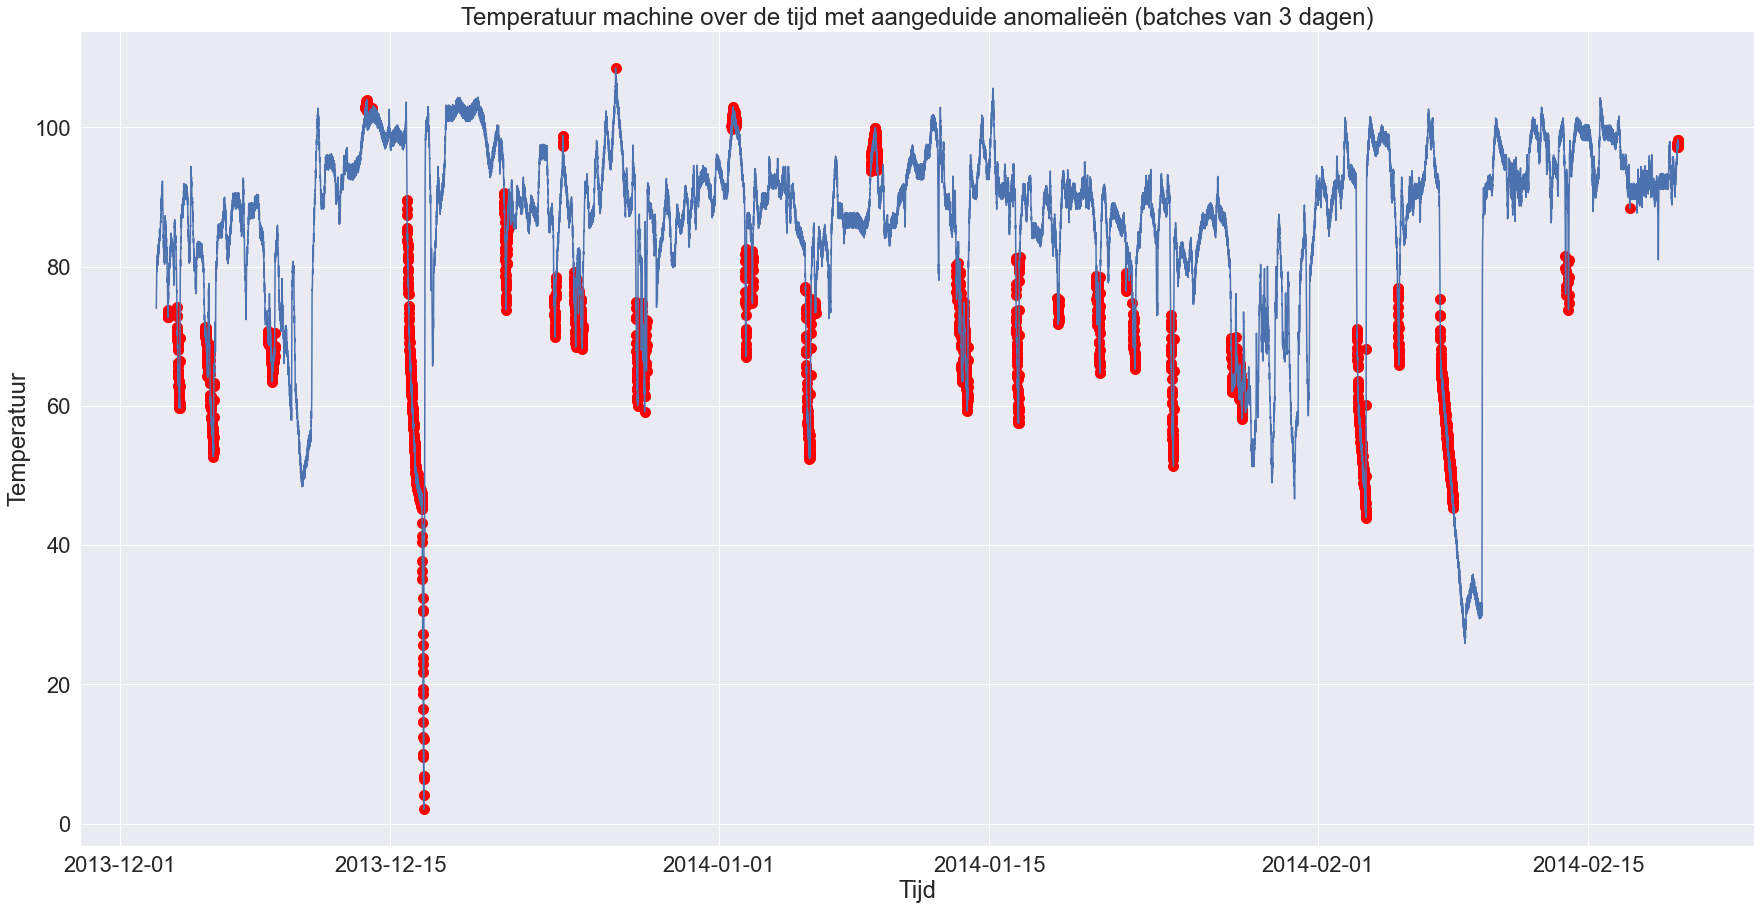

In [82]:
# Plotten van beide grafieken
sns.set(rc={'figure.figsize':(30,15)})
sns.set(font_scale=2)

plt.plot(temperature_timestamp_index_days.index, temperature_timestamp_index_days['value'])
plt.scatter(anomalies_days['timestamp'], anomalies_days['value'], c='Red', s=100)
plt.xlabel("Tijd")
plt.ylabel("Temperatuur")
plt.title("Temperatuur machine over de tijd met aangeduide anomalieën (batches van 3 dagen)")
plt.show()